# Ein eigenes "Thug Cats" Modell trainieren
### codecentric.ai Bootcamp

1. melde dich bei kaggle.com an
2. suche nach "cats dataset"
3. lade cats.zip Datei herunter (~ 2 GB)
4. entpacke die zip Datei in einen Ordner (z.B. /data/cats/)

Für das Training verwenden wir fastai:

In [261]:
from fastai.basics import *
from fastai.vision import *

### Daten auspacken und ansehen

In [14]:
# Pfad zu den Daten
path = Path("/data/cats")

Die Bilder und Labels liegen in Unterordnern CAT_00 - CAT_06:

In [21]:
os.listdir(path)

['models',
 'export.pkl',
 'CAT_02',
 'CAT_00',
 'cat_hipster.py~',
 'CAT_03',
 'CAT_06',
 'CAT_01',
 'cat_hipster.py',
 'CAT_05',
 'CAT_04',
 'requirements.txt']

In einem Unterornder sehen die Daten so aus:

In [29]:
sorted(os.listdir(path/'CAT_00'))[:5]

['00000001_000.jpg',
 '00000001_000.jpg.cat',
 '00000001_005.jpg',
 '00000001_005.jpg.cat',
 '00000001_008.jpg']

### Bilder und Labels visualisieren

Wir schauen uns ein konkretes Beispiel an, bevor wir unser Modell trainieren, um zu verstehen, wie die Daten strukturiert sind. Dazu picken wir uns einfach einen Dateinamen raus:

In [34]:
sample_str = "CAT_00/00000001_005.jpg"
sample_img = open_image(path/sample_str)
sample_labels_file = path/str(sample_str+".cat")

Die ".cat" Datei ist ein einfaches Text-File mit Zahlenwerten. 

Anhand des Dateinamens wird sie dem entsprechenden Bild zugeordnet 
(xx1_005.jpg.cat sind die Labels für xx1_005.jpg )

In [43]:
f = open(sample_labels_file, "r")
print(f.readline())
f.close()

9 96 96 153 127 103 146 48 20 78 -37 127 5 210 52 260 63 229 121 


Jetzt lesen wir die ".cat" Datei in ein numpy Array ein:

In [45]:
sample_points = np.genfromtxt(sample_labels_file)

Damit haben wir die Labels in einem Array.

- die erste Zahl bedeutet die Anzahl der Datenpunkte (immer 9)
- dann folgen jeweils Tupel, die einen Bild Punkt bedeuten
- der erste Tupel ist (x, y) vom linken Auge
- der zweite Tupel ist (x, y) vom rechten Auge
- die Reihenfolge der Labels ist immer gleich

In [46]:
sample_points

array([  9.,  96.,  96., 153., 127., 103., 146.,  48.,  20.,  78., -37., 127.,   5., 210.,  52., 260.,  63., 229.,
       121.])

Jetzt bringen wir die Daten noch in ein passendes Format:

In [262]:
# die erste Zahl ist immer 9 - die brauchen wir nicht
sample_np = sample_points[1:]

# jetzt vertauschen wir noch pro Tupel y->x, also aus p2=(153, 127) wird (127, 153)
# dies macht es einfacher die vorhandenen Visualisierungsfunktionen zu verwenden
# je nachdem welche library man verwendet kann es sein, dass man dort einen punkt mit (x,y) oder mit (y,x) definiert
sample_np = np.array(sample_np.reshape(9,2)[:, ::-1])

Nun wandeln wir den Array in einen Tensor um:

In [49]:
sample_tensor = torch.tensor(sample_np, dtype=torch.float)

Und schließlich bringen wir das ganze in das Daten-Format mit dem fastai arbeitet, um Bilder und Bildpunkte als Labels anzeigen zu können:

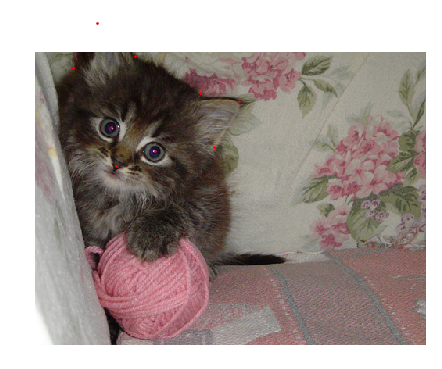

In [53]:
flow_field = FlowField(sample_img.size, sample_tensor)
image_points = ImagePoints(flow_field, scale=True)
sample_img.show(y=image_points, figsize=(7, 7))

Wir sehen, dass das Bild richtig angezeigt wird.

Außerdem sehen wir, dass die Labels (rote Punkte) an den richtigen Stellen angezeigt werden. 

Damit sind wir sicher, dass wir die Struktur der Daten verstanden haben und sind bereit, unser Modell zu trainieren.

# Databunch erstellen

In fastai gibt es ein sogenanntes "databunch".

Darin sind viele Schritte gekapselt:

- Daten laden
- Daten labeln
- Daten transformieren / normalisieren
- aufsplitten in TRAIN und VALIDATION sets
- aufsplitten in Batches
- etc.

In [54]:
path = Path("data/cats/")

Aus dem Beispiel-Bild oben, wissen wir, wie wir die Labels strukturieren müssen, damit die Library damit arbeiten kann. Diese Schritte packen wir nun in eine Funktion, um sie auf alle Bilder anwenden zu können:

In [55]:
def get_keypoints(file_name):
    file_name = str(file_name)+".cat"
    keypoints = np.genfromtxt(file_name)[1:]
    keypoints = np.array(keypoints.reshape(9,2)[:, ::-1])
    t = torch.tensor(keypoints, dtype=torch.float)
    return t

Mit dieser Funktion können wir nun ein databunch erzeugen. Dieser liest alle Bilder unter `path`, splittet die Daten zufällig in Train- und Validation-Set, ermittelt die Labels mit der oben definierten Funktion, bringt die Bilder in eine einheitliche Größe und normalisiert die Bilddaten:

In [104]:
# mit dieser Bildgröße soll unser neuronales Netz trainieren
size = (220, 300)
# das ist die Batch-Size
bs = 64

data = (PointsItemList.from_folder(path)
        #.filter_by_func(lambda o: str(o).endswith('.jpg'))
        .split_by_rand_pct()
        .label_from_func(get_keypoints)
        #.transform(get_transforms(), tfm_y=True, size=size, remove_out=False)
        .transform([], tfm_y=False, size=size)
        .databunch(bs=bs).normalize(imagenet_stats)
       )

Jetzt haben wir ein "data" Objekt und können es verwenden, um die Daten zu laden und anzuzeigen (so wie sie dann für das Training verwendet werden, inklusive Resizing etc.)

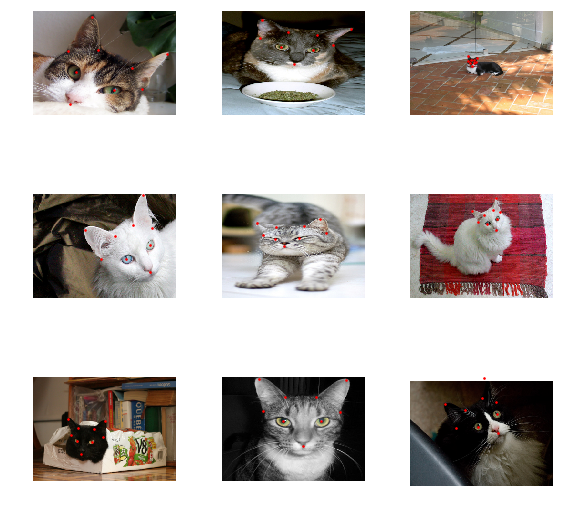

In [264]:
data.show_batch(rows=3, figsize=(8, 8))

Die Daten sehen gut aus, jetzt können wir unser Modell definieren.

# Modell (bzw. learner) definieren

Dazu verwenden wir ein pretrained ResNet34. Wir machen uns keine großen Gedanken, um die Architektur des neuronalen Netzes - sondern probieren einfach einmal aus, wie weit wir mit einer modernen Standard-Architektur kommen.

In [106]:
learn = cnn_learner(data, models.resnet34, pretrained=True)

Folgende Funktion aus fastai macht ein kleines "Probe-Training" und hilft uns dabei abzuschätzen, wie groß die learning rate sein sollte. 

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


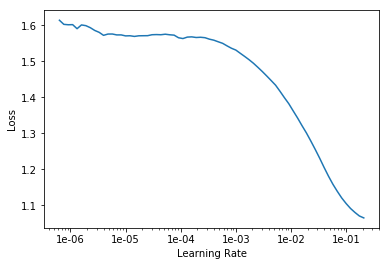

In [107]:
learn.lr_find()
learn.recorder.plot()

In [108]:
lr = 1e-2

## Training starten

Jetzt haben wir alle Vorbereitungen getroffen und können das Training des Modells starten.

Wir trainieren erstmal 3 Epochen und schauen uns dann an, ob unser Netz etwas "Sinnvolles" lernt.

In [109]:
learn.fit(3, lr)

epoch,train_loss,valid_loss,time
0,0.109162,0.051947,00:29
1,0.039688,0.019076,00:29
2,0.021219,0.016075,00:29


train_loss und valid_loss werden kleiner -> schon mal gut.

Mit der folgenden Methode können wir mit dem aktuellen Modell ein paar Predictions machen lassen und visualisieren, wie gut/schlecht es funktioniert. 

In der linken Spalte sieht man den "Ground truth" (also das Label) und in der Spalte rechts daneben die Vorhersage, die das Modell für dieses Bild gemacht hat:

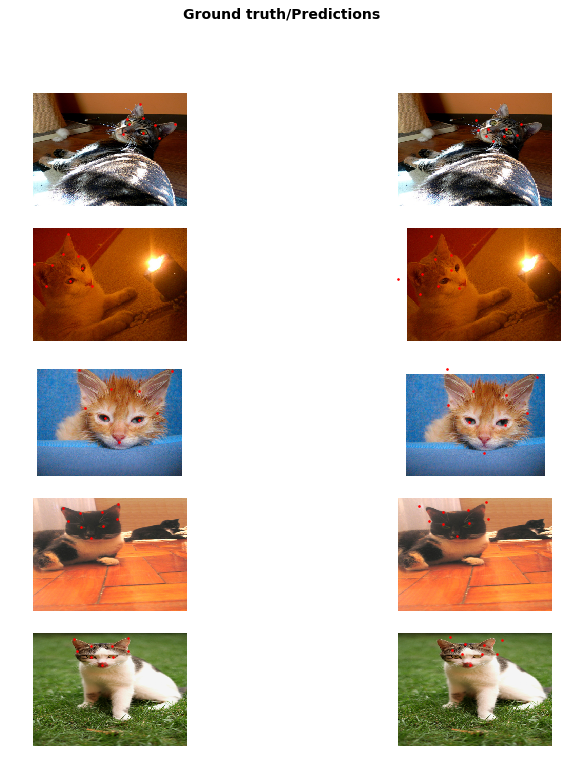

In [110]:
learn.show_results(rows=5, figsize=(12, 12))

Man sieht, dass die Punkte schon in der Nähe des Kopfes sind - aber sie markieren noch nicht wirklich Augen, Ohren etc. Wir versuchen also noch weiter zu trainieren, um das Modell zu verbessern. 

Dazu machen wir zunächst ein "unfreeze" - das heisst wir trainieren jetzt alle Layer und nicht nur die letzten.

In [112]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


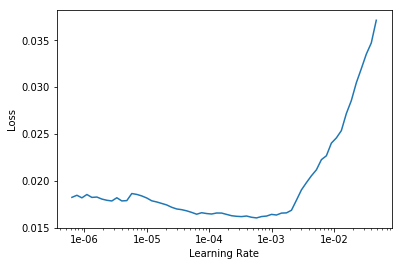

In [113]:
learn.lr_find()
learn.recorder.plot()

Jetzt verwenden wir eine optimierte fit Methode und lassen das Modell einfach mal eine Weile trainieren.

Zeit für einen Kaffee (oder 2). 

Nur so nebenbei: das Modell trainiert nicht schneller oder besser, wenn man dem Progress-Bar zuschaut - aber viele machen es trotzdem ;)

In [192]:
lr = 4e-4
learn.fit_one_cycle(20, slice(lr))

epoch,train_loss,valid_loss,time
0,0.004511,0.004378,00:36
1,0.004772,0.005215,00:35
2,0.004993,0.004872,00:35
3,0.005017,0.004589,00:35
4,0.004570,0.004008,00:36
5,0.004458,0.004034,00:36
6,0.004348,0.003763,00:36
7,0.003884,0.003802,00:36
8,0.004021,0.003620,00:36
9,0.003923,0.003811,00:35


Mit der folgenden Funktion können wir den Verlauf train_loss und valid_loss visualisieren:

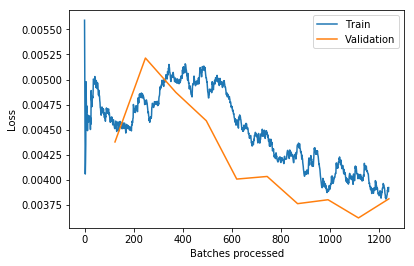

In [193]:
learn.recorder.plot_losses()

Um das Training nicht immer wieder von vorne beginnen zu müssen, kann man den aktuellen Stand in einer Datei speichern (und einfach und schnell wieder laden, falls man etwas "kaputt" macht oder das nächste Experiment in die falsche Richtung geht):

In [194]:
learn.save('thug_cat_resnet34_v1')
learn.load('thug_cat_resnet34_v1')

Learner(data=ImageDataBunch;

Train: LabelList (7998 items)
x: PointsItemList
Image (3, 220, 300),Image (3, 220, 300),Image (3, 220, 300),Image (3, 220, 300),Image (3, 220, 300)
y: PointsLabelList
ImagePoints (1024, 713),ImagePoints (495, 330),ImagePoints (353, 500),ImagePoints (679, 1024),ImagePoints (1024, 853)
Path: data/cats;

Valid: LabelList (1999 items)
x: PointsItemList
Image (3, 220, 300),Image (3, 220, 300),Image (3, 220, 300),Image (3, 220, 300),Image (3, 220, 300)
y: PointsLabelList
ImagePoints (500, 470),ImagePoints (375, 500),ImagePoints (768, 1024),ImagePoints (500, 401),ImagePoints (1024, 683)
Path: data/cats;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Ba

Jetzt schauen wir uns noch einmal an, ob sich das Modell verbessert hat:

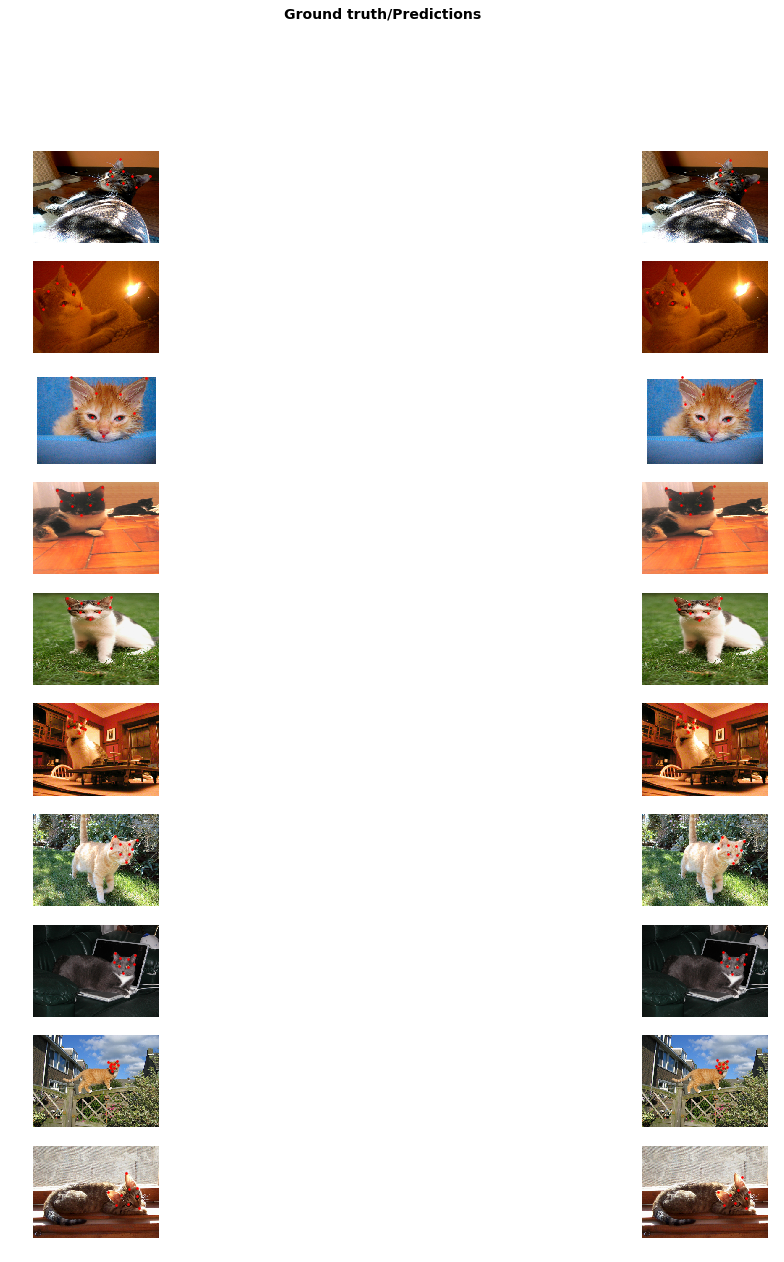

In [195]:
learn.show_results(rows=10, figsize=(20, 20))

Man sieht, dass die Predictions nun schon ganz gut auf die entsprechenden Punkte passen.

Man könnte versuchen, mit weiteren Trainingsrunden das Ergebnis weiter zu verbessern.


Wenn man denkt, dass Ergebnis ist gut genug, dann kann man das Modell mit folgendem Befehl in eine Datei exportieren:

In [196]:
learn.export('thug_cat_export.pkl')

# Modell verwenden um Vorhersagen zu machen

Als Vorbereitung auf unsere WebApp mit der Sonnenbrille versuchen wir jetzt unser Modell mit Bildern aus dem Internet (die es hoffentlich nicht aus dem Training kennt):

In [212]:
#!wget -O test.jpg 'https://cdn.pixabay.com/photo/2014/03/29/09/17/cat-300572_1280.jpg'
!wget -O test.jpg 'https://cdn.pixabay.com/photo/2015/01/31/12/36/cat-618470__480.jpg'

--2019-04-23 15:52:00--  https://cdn.pixabay.com/photo/2015/01/31/12/36/cat-618470__480.jpg
Resolving cdn.pixabay.com (cdn.pixabay.com)... 104.18.82.97, 104.18.141.87, 2606:4700::6812:8d57, ...
Connecting to cdn.pixabay.com (cdn.pixabay.com)|104.18.82.97|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46656 (46K) [image/jpeg]
Saving to: ‘test.jpg’

test.jpg            100%[===================>]  45,56K  --.-KB/s    in 0,006s  

2019-04-23 15:52:00 (6,89 MB/s) - ‘test.jpg’ saved [46656/46656]



Zunächst laden wir das Bild und zeigen es an:

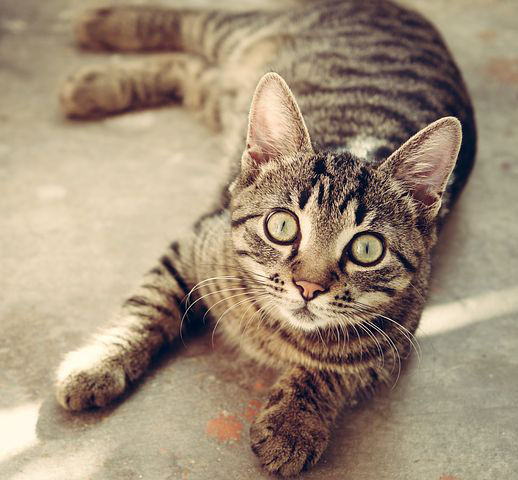

In [244]:
pred_img = open_image("test.jpg")
pred_img

Jetzt erstellen wir einen neuen "learner" und laden die vorher exportierte ".pkl" Datei:

In [254]:
test_learner = load_learner(path, 'thug_cat_export.pkl')

Damit können wir jetzt eine Vorhersage machen:

In [255]:
predicted_image_points, pred, out = test_learner.predict(pred_img)

Die ImagePoints können wir wieder direkt verwenden, um sie mit Boardmitteln zu visualisieren - sie müssen aber von der Skalierung zu unserem Modell passen.

In [256]:
predicted_image_points

ImagePoints (220, 300)

Alternativ gibt das Modell auch die "raw" Predictions aus. Diese sind sind in einem Werte-Bereich, den wir erst auf die Größe des getesteten Bildes umrechnen müssten.

In [257]:
pred

tensor([[-0.0469,  0.0987],
        [ 0.0310,  0.4107],
        [ 0.2483,  0.1883],
        [-0.2288, -0.0691],
        [-0.6508,  0.0170],
        [-0.3432,  0.1973],
        [-0.2701,  0.4536],
        [-0.4519,  0.7510],
        [-0.0418,  0.6545]])

Wenn wir also ein Bild mit einer anderen Größe als `size` verwenden, dann passen die Predictions scheinbar nicht:

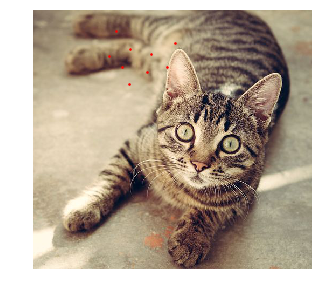

In [258]:
pred_img.show(y=predicted_image_points, figsize=(5, 5))

Skalieren wir aber das Bild wieder auf die beim Training verwendete `size`:

In [259]:
resized_pred_img = pred_img.clone().resize((3, *size))

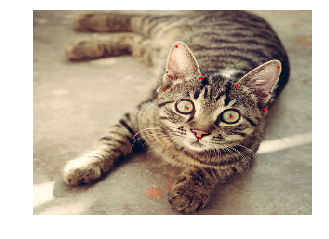

In [260]:
resized_pred_img.show(y=predicted_image_points, figsize=(5, 5))

... dann sieht das Ergebnis vielversprechend aus. Mit diesem Modell wollen wir Anschluss eine WebApp bereitstellen, die eine Sonnenbrille automatisch an die vorhergesagten Punkte der Augen platziert. Sinnvoller ist es natürlich die Bildpunkte entsprechend zu transformieren, so dass sie zu den Größenverhältnissen des Bildes passen. Das implementieren wir in der WebApp.

### Referenzen

Cat Dataset:

Weiwei Zhang, Jian Sun, and Xiaoou Tang, Cat Head Detection - How to Effectively Exploit Shape and Texture Features, Proc. of European Conf. Computer Vision, vol. 4, pp.802-816, 2008.

- fastai: https://www.fast.ai/
- Kaggle: https://www.kaggle.com/
- Bilder: https://pixabay.com/

https://bootcamp.codecentric.ai/
